<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTS1] - CNN with GTSRB dataset - Data analysis and preparation
<!-- DESC --> Episode 1 : Data analysis and creation of a usable dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understand the **complexity associated with data**, even when it is only images
 - Learn how to build up a simple and **usable image dataset**

The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  

Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :

 - Understanding the dataset
 - Preparing and formatting enhanced data
 - Save enhanced datasets in h5 file format


## Step 1 -  Import and init

In [1]:
import os, time, sys
import csv
import math, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('GTS1')

**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : GTS1
Run time             : Wednesday 30 December 2020, 22:06:55
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run
CI running mode      : none
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Read the dataset
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
 - Each directory contains one CSV file with annotations : `GT-<ClassID>.csv` and the training images
 - First line is fieldnames: `Filename ; Width ; Height ; Roi.X1 ; Roi.Y1 ; Roi.X2 ; Roi.Y2 ; ClassId`
    
### 2.1 - Understanding the dataset
The original dataset is in : **\<dataset_dir\>/GTSRB/origine.**  
There is 3 subsets : **Train**, **Test** and **Meta.**  
Each subset have an **csv file** and a **subdir.**
    

In [2]:
df = pd.read_csv(f'{datasets_dir}/GTSRB/origine/Test.csv', header=0)
display(df.head(10))

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


### 2.2 - Usefull functions
A nice function to read a subset :

In [3]:
def  read_csv_dataset(csv_file): 
    '''
    Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.
    Arguments:  
        csv filename :  Description file, Example /data/GTSRB/Train.csv
    Returns:
        x,y          :  np array of images, np array of corresponding labels
    '''

    path = os.path.dirname(csv_file)
    name = os.path.basename(csv_file)

    # ---- Read csv file
    #
    df = pd.read_csv(csv_file, header=0)
    
    # ---- Get filenames and ClassIds
    #
    filenames = df['Path'].to_list()
    y         = df['ClassId'].to_list()
    x         = []
    
    # ---- Read images
    #
    for filename in filenames:
        image=io.imread(f'{path}/{filename}')
        x.append(image)
        pwk.update_progress(name,len(x),len(filenames))
    
    # ---- Return
    #
    return np.array(x,dtype=object),np.array(y)

### 2.2 - Read the data
We will read the following datasets:
 - **Train** subset, for learning data as :  `x_train, y_train`
 - **Test** subset, for validation data as :  `x_test, y_test`
 - **Meta** subset, for visualisation as : `x_meta, y_meta`
 
The learning data will be randomly mixted and the illustration data (Meta) sorted.  
Will take about 1'30s on HPC.

In [4]:
%%time

# ---- Read datasets

(x_train,y_train) = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Train.csv')
(x_test ,y_test)  = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Test.csv')
(x_meta ,y_meta)  = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Meta.csv')
    
# ---- Shuffle train set

x_train, y_train = pwk.shuffle_np_dataset(x_train, y_train)

# ---- Sort Meta

combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

Train.csv        [########################################] 100.0% of 39209
Test.csv         [########################################] 100.0% of 12630
Meta.csv         [########################################] 100.0% of 43
CPU times: user 15.4 s, sys: 880 ms, total: 16.3 s
Wall time: 16.2 s


## Step 3 - Few statistics about train dataset
We want to know if our images are homogeneous in terms of size, ratio, width or height.

### 3.1 - Do statistics 

In [5]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

### 3.2 - Show statistics

x_train shape :  (39209,)
y_train shape :  (39209,)
x_test  shape :  (12630,)
y_test  shape :  (12630,)


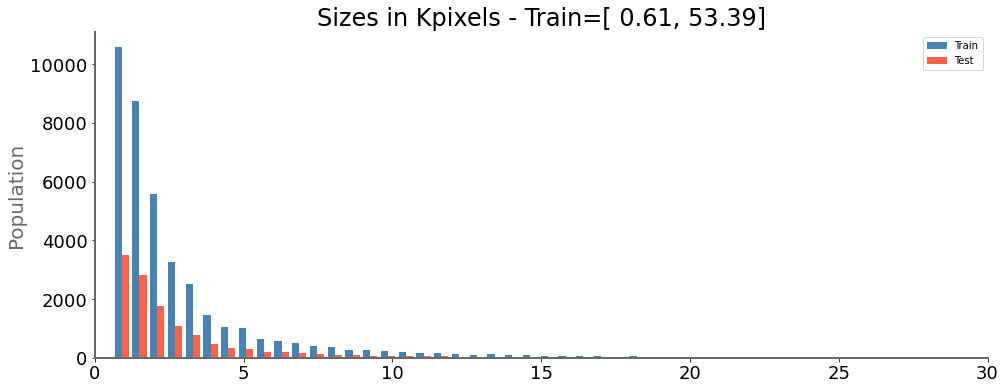

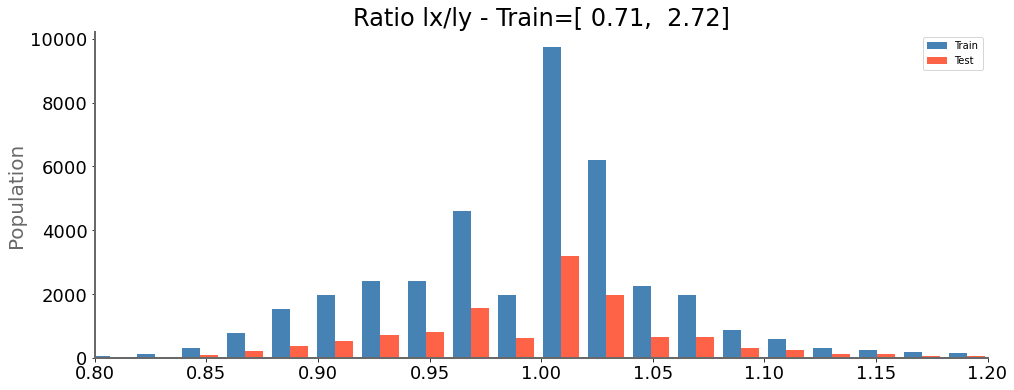

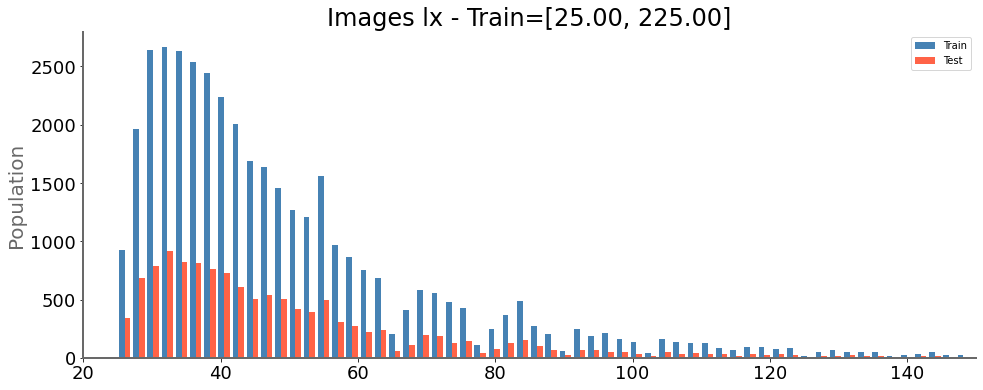

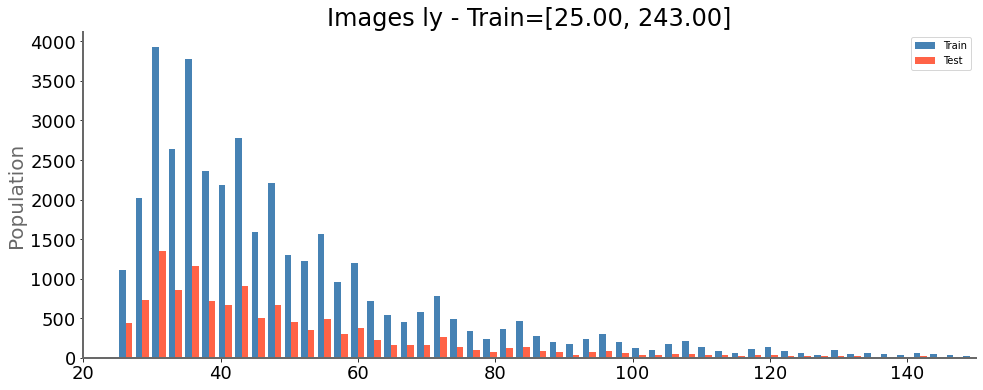

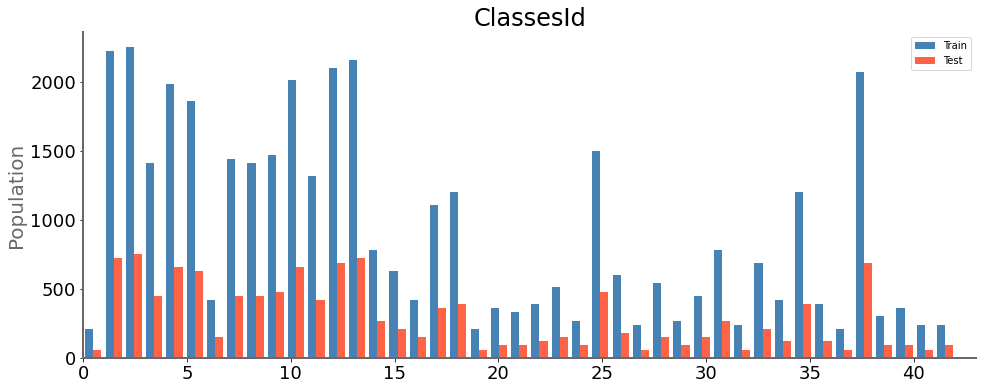

In [6]:
# ------ Global stuff
print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("x_test  shape : ",x_test.shape)
print("y_test  shape : ",y_test.shape)

# ------ Statistics / sizes
plt.figure(figsize=(16,6))
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population', xlim=[0,30])
plt.legend(['Train','Test'])
pwk.save_fig('01-stats-sizes')
plt.show()

# ------ Statistics / ratio lx/ly
plt.figure(figsize=(16,6))
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population', xlim=[0.8,1.2])
plt.legend(['Train','Test'])
pwk.save_fig('02-stats-ratios')
plt.show()

# ------ Statistics / lx
plt.figure(figsize=(16,6))
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
pwk.save_fig('03-stats-lx')
plt.show()

# ------ Statistics / ly
plt.figure(figsize=(16,6))
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
pwk.save_fig('04-stats-ly')
plt.show()

# ------ Statistics / classId
plt.figure(figsize=(16,6))
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', ylabel='Population', xlim=[0,43])
plt.legend(['Train','Test'])
pwk.save_fig('05-stats-classes')
plt.show()

## Step 4 - List of classes
What are the 43 classes of our images...

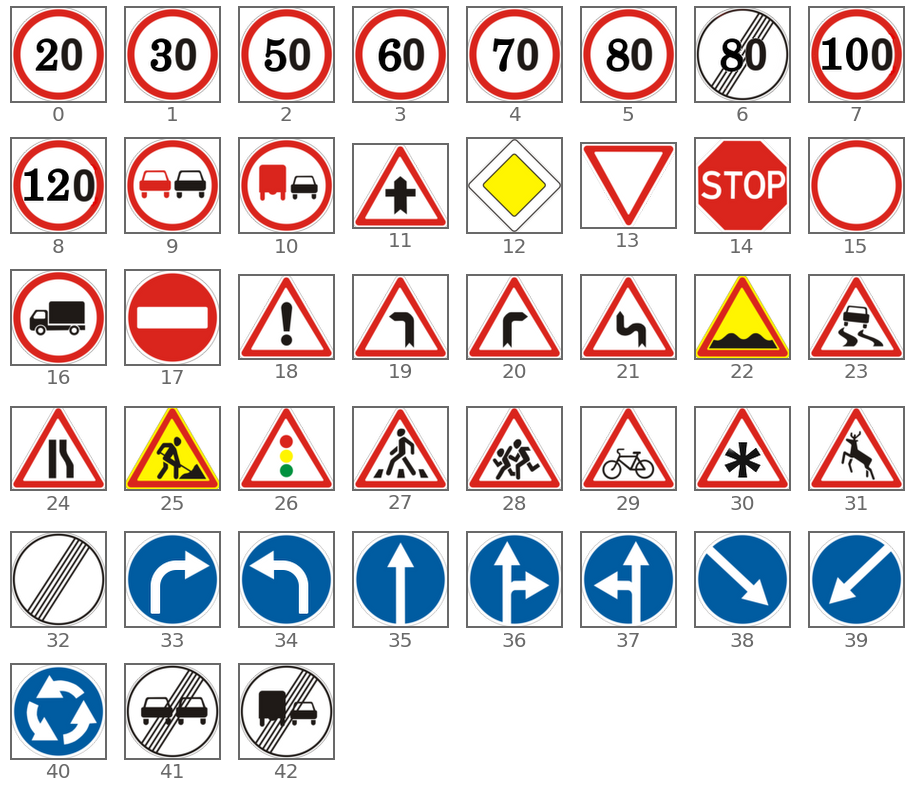

In [7]:
pwk.plot_images(x_meta,y_meta, range(43), columns=8, x_size=2, y_size=2, 
                                colorbar=False, y_pred=None, cm='binary', save_as='06-meta-signs')

## Step 5 - What does it really look like

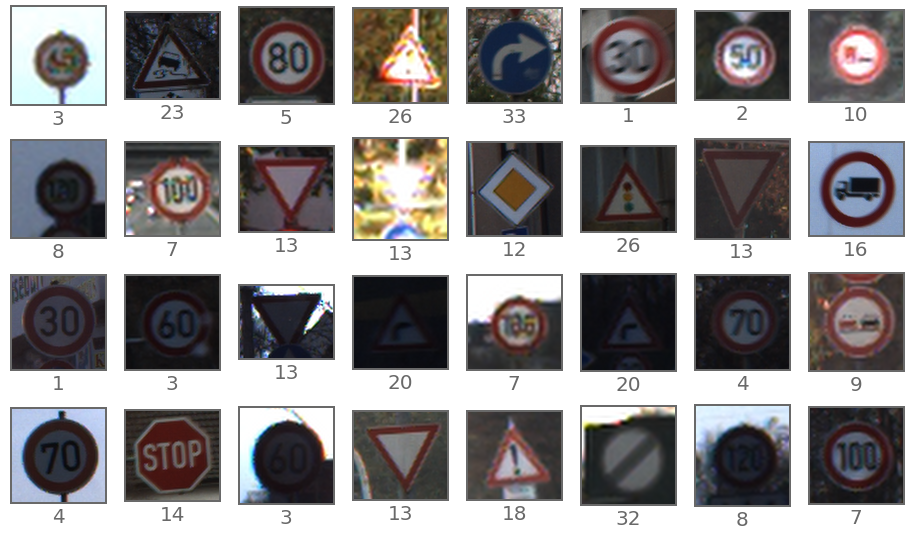

In [8]:
# ---- Get and show few images

samples = [ random.randint(0,len(x_train)-1) for i in range(32)]
pwk.plot_images(x_train,y_train, samples, columns=8, x_size=2, y_size=2, 
                colorbar=False, y_pred=None, cm='binary', save_as='07-real-signs')


## Step 6 - dataset cooking...

Images **must** :
 - have the **same size** to match the size of the network,
 - be **normalized**.  
 
It is possible to work on **rgb** or **monochrome** images and to **equalize** the histograms.   

See : [Exposure with scikit-image](https://scikit-image.org/docs/dev/api/skimage.exposure.html)  
See : [Local histogram equalization](https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.equalize)  
See : [Histogram equalization](https://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist)  

### 6.1 - Enhancement cooking

In [9]:
def images_enhancement(images, width=25, height=25, mode='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    Note : all outputs are fixed size numpy array of float64
    args:
        images :         images list
        width,height :   new images size (25,25)
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE
    return:
        numpy array of enhanced images
    '''
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}
    lz=modes[mode]
    
    out=[]
    for img in images:
        
        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)
            
        # ---- Resize
        img = transform.resize(img, (width,height))

        # ---- RGB / Histogram Equalization
        if mode=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
        # ---- Grayscale
        if mode=='L':
            img=color.rgb2gray(img)
            
        # ---- Grayscale / Histogram Equalization
        if mode=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- Grayscale / Local Histogram Equalization
        if mode=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if mode=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)
            
        # ---- Add image in list of list
        out.append(img)
        pwk.update_progress('Enhancement: ',len(out),len(images))

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz)
    return out

### 6.2 - To get an idea of the different recipes

Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16


<br>**EXPECTED**

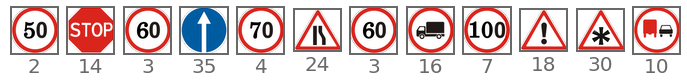

<br>**ORIGINAL**

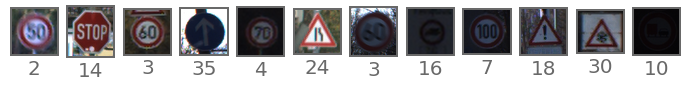

<br>**ENHANCED**

dataset : RGB  min,max=[0.016,1.000]  shape=(16, 25, 25, 3)


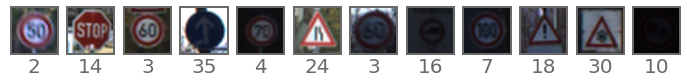

dataset : RGB-HE  min,max=[0.001,1.000]  shape=(16, 25, 25, 3)


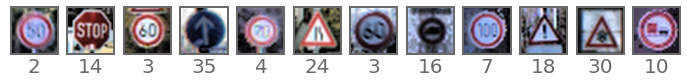

dataset : L  min,max=[0.016,1.000]  shape=(16, 25, 25, 1)


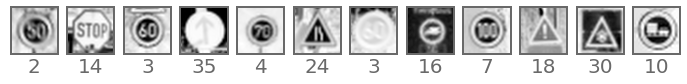

dataset : L-HE  min,max=[0.002,1.000]  shape=(16, 25, 25, 1)


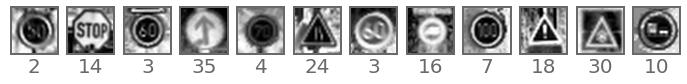

dataset : L-LHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


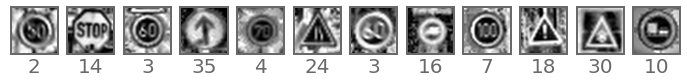

dataset : L-CLAHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


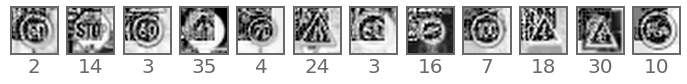

In [10]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

datasets  = {}

datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, mode='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, mode='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, mode='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, mode='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, mode='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, mode='L-CLAHE'  )

pwk.subtitle('EXPECTED')
x_expected=[ x_meta[i] for i in y_samples]
pwk.plot_images(x_expected, y_samples, range(12), columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', save_as='08-expected')

pwk.subtitle('ORIGINAL')
pwk.plot_images(x_samples,  y_samples, range(12), columns=12, x_size=1, y_size=1, 
                colorbar=False, y_pred=None, cm='binary', save_as='09-original')

pwk.subtitle('ENHANCED')
n=10
for k,d in datasets.items():
    print("dataset : {}  min,max=[{:.3f},{:.3f}]  shape={}".format(k,d.min(),d.max(), d.shape))
    pwk.plot_images(d, y_samples, range(12), columns=12, x_size=1, y_size=1, 
                    colorbar=False, y_pred=None, cm='binary', save_as=f'{n}-enhanced-{k}')
    n+=1


### 6.3 - Cook and save
A function to save a dataset

In [11]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, filename):
        
    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)
        
    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

The generation of datasets may require some time and space (10' and 10 GB).  

**Important :**  
You can choose to perform tests or generate the whole enhanced dataset by setting the following parameters:  
`scale` : 1 mean 100% of the dataset - set 0.1 for tests  
`output_dir` : where to write clusters, could be :
 - `./data`, for tests purpose
 - `<datasets_dir>/celeba/enhanced` to add clusters in your datasets dir.  

In [12]:
%%time

# ---- Parameters you can set :

# For tests :
#
scale      = 0.1
output_dir = './data' 

# Full generation :
#
# scale      = 1
# output_dir = f'{datasets_dir}/GTSRB/enhanced'

# ---- Used for continous integration - Just forget this lines
#
scale      = pwk.override('scale',      scale,      smart=0.1,      full=1.0)
output_dir = pwk.override('output_dir', output_dir, smart='./data', full=f'{datasets_dir}/GTSRB/enhanced')
    
# ---- Generate enhanced datasets
#
n_train = int( len(x_train)*scale )
n_test  = int( len(x_test)*scale )

pwk.subtitle('Parameters :')
print(f'Scale is : {scale}')
print(f'x_train length is : {n_train}')
print(f'x_test  length is : {n_test}')
print(f'output dir is     : {output_dir}\n')

pwk.subtitle('Running...')

pwk.mkdir(output_dir)

for s in [24, 48]:
    for m in ['RGB', 'RGB-HE', 'L', 'L-LHE']:
        # ---- A nice dataset name
        filename = f'{output_dir}/set-{s}x{s}-{m}.h5'
        pwk.subtitle(f'Dataset : {filename}')
        
        # ---- Enhancement
        #      Note : x_train is a numpy array of python objects (images with <> sizes)
        #             but images_enhancement() return a real array of float64 numpy (images with same size)
        #             so, we can save it in nice h5 files
        #
        x_train_new = images_enhancement( x_train[:n_train], width=s, height=s, mode=m )
        x_test_new  = images_enhancement( x_test[:n_test],  width=s, height=s, mode=m )
        x_meta_new  = images_enhancement( x_meta,  width=s, height=s, mode='RGB' )
        
        # ---- Save
        save_h5_dataset( x_train_new, y_train, x_test_new, y_test, x_meta_new,y_meta, filename)

x_train_new,x_test_new=0,0
print('\n')


<br>**Parameters :**

Scale is : 0.2
x_train length is : 7841
x_test  length is : 2526
output dir is     : ./data



<br>**Running...**

<br>**Dataset : ./data/set-24x24-RGB.h5**

Enhancement:     [########################################] 100.0% of 7841
Enhancement:     [########################################] 100.0% of 2526
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-RGB.h5   shape : (7841, 24, 24, 3)      size :  137.6 Mo   (saved)


<br>**Dataset : ./data/set-24x24-RGB-HE.h5**

Enhancement:     [########################################] 100.0% of 7841
Enhancement:     [########################################] 100.0% of 2526
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-RGB-HE.h5  shape : (7841, 24, 24, 3)      size :  137.6 Mo   (saved)


<br>**Dataset : ./data/set-24x24-L.h5**

Enhancement:     [########################################] 100.0% of 7841
Enhancement:     [########################################] 100.0% of 2526
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-L.h5     shape : (7841, 24, 24, 1)      size :   46.5 Mo   (saved)


<br>**Dataset : ./data/set-24x24-L-LHE.h5**

Enhancement:     [########################################] 100.0% of 7841
Enhancement:     [########################################] 100.0% of 2526
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-L-LHE.h5  shape : (7841, 24, 24, 1)      size :   46.5 Mo   (saved)


<br>**Dataset : ./data/set-48x48-RGB.h5**

Enhancement:     [########################################] 100.0% of 7841
Enhancement:     [########################################] 100.0% of 2526
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-RGB.h5   shape : (7841, 48, 48, 3)      size :  549.4 Mo   (saved)


<br>**Dataset : ./data/set-48x48-RGB-HE.h5**

Enhancement:     [########################################] 100.0% of 7841
Enhancement:     [########################################] 100.0% of 2526
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-RGB-HE.h5  shape : (7841, 48, 48, 3)      size :  549.4 Mo   (saved)


<br>**Dataset : ./data/set-48x48-L.h5**

Enhancement:     [########################################] 100.0% of 7841
Enhancement:     [########################################] 100.0% of 2526
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-L.h5     shape : (7841, 48, 48, 1)      size :  184.9 Mo   (saved)


<br>**Dataset : ./data/set-48x48-L-LHE.h5**

Enhancement:     [########################################] 100.0% of 7841
Enhancement:     [########################################] 100.0% of 2526
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-L-LHE.h5  shape : (7841, 48, 48, 1)      size :  184.9 Mo   (saved)


CPU times: user 4min 30s, sys: 2min 12s, total: 6min 43s
Wall time: 2min 15s


<div class='todo'>
  Adapt the code below to read :
  <ul>
      <li>the different h5 datasets you saved in ./data,</li>
      <li>The h5 datasets available in the Fidle project datasets directory.</li>
  </ul>
 
</div>

## Step 7 - Reload data to be sure ;-)

dataset loaded from h5 file.


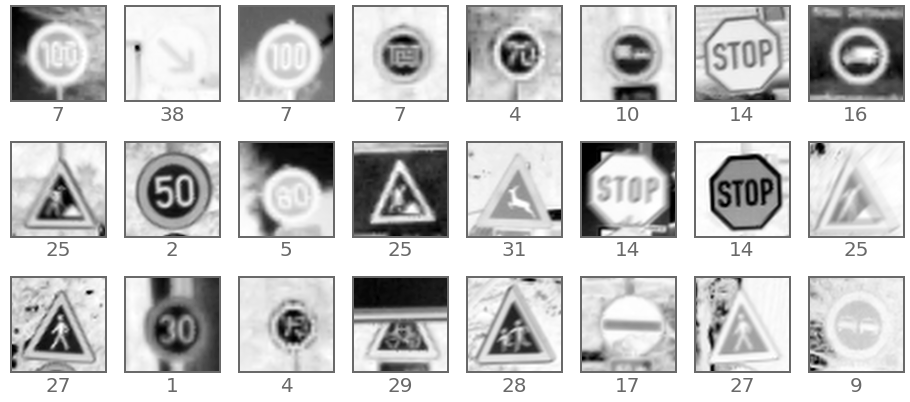

CPU times: user 4.27 s, sys: 41.1 ms, total: 4.31 s
Wall time: 4.3 s


In [13]:
%%time

dataset='set-48x48-L'
samples=range(24)

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    print("dataset loaded from h5 file.")

pwk.plot_images(x_tmp,y_tmp, samples, columns=8, x_size=2, y_size=2, 
                colorbar=False, y_pred=None, cm='binary', save_as='16-enhanced_images')
x_tmp,y_tmp=0,0

In [14]:
pwk.end()

End time is : Wednesday 30 December 2020, 22:10:00
Duration is : 00:03:05 030ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>